In [1]:
import os
n_cores = 4
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count={}'.format(n_cores)

from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
import pickle
from jax import jit, vmap, grad, jacrev
from jax.lax import cond, scan
import jax.random as random
key = random.PRNGKey(2022)
import jax.example_libraries.optimizers as optimizers
from jax.flatten_util import ravel_pytree
from jax.sharding import PositionalSharding
from functools import partial

import matplotlib.pyplot as plt
import pandas as pd

from utils import train, coords_2_strain_nn
from utils import train_colloc_parallel as train_colloc, init_params_nn, ff_nn, divergence, bd_forces, a1, a2, lr
from utils_hyperelasticity import NODE, init_layers, NODE_model_aniso, init_params_aniso, GOH_model, eval_Cauchy, eval_Cauchy_vmap, eval_P, eval_P_vmap
from utils_hyperelasticity import ThreeDElasticity
from fem import plotmesh, fe_solver_2D, vahid_anisohyper_inv, apply_bc_biax

from jax_fem.core import FEM
from jax_fem.solver import solver
from jax_fem.utils import save_sol
from jax_fem.generate_mesh import box_mesh, get_meshio_cell_type, Mesh, rectangle_mesh

from PIL import Image, ImageFilter
from jaxinterp2d import interp2d

E_fun = vmap(lambda F: 0.5*(F.T@F - jnp.eye(2)))

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



## 1. Generate data + pretraining

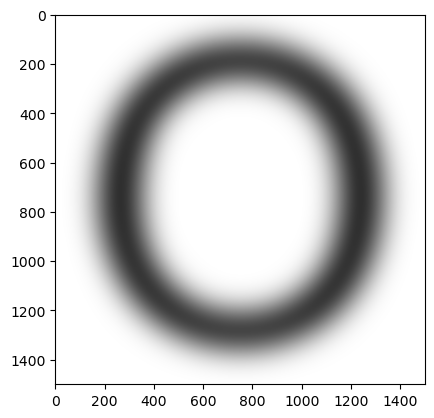

In [2]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)
Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])
image = Image.open('data/O.png')
image = image.filter(ImageFilter.GaussianBlur(radius=60))
plt.imshow(image)
image = image.rotate(-90)
image = np.array(image)
image = image.mean(axis=2)
image = image/image.max()

pts_x = np.linspace(0,1,image.shape[0])
pts_y = np.linspace(0,1,image.shape[1])

def coords_2_params_gt(xy):
    x, y = xy
    c = interp2d(x,y,pts_x,pts_y,image)
    return jnp.stack([0.5,0.10,0.20,0.1,0.0]) + c*jnp.stack([0.2,0.02,0.04,0.0,0.0])

In [3]:
GOH_P_vmap = vmap(ThreeDElasticity(GOH_model).ugrad_2_P, in_axes=(0, 0, None))
class HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: ThreeDElasticity(GOH_model).ugrad_2_P(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [4]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 50, 50
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = np.linspace(1.05,1.20,15)
n_elem = Nx*Ny
F_hist_goh = []
P_hist_goh = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    # params = vmap(coords_2_params_gt)(elem_X)
    params = []
    for xy in elem_X:
        params.append(coords_2_params_gt(xy))
    params = np.expand_dims(params, 1)
    params_vec = jnp.repeat(params, axis=1, repeats=4)
    problem.set_params(params_vec)


    u = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(u), axis=1)
    F = u_grad + np.eye(2)

    P = GOH_P_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist_goh.append(F)
    P_hist_goh.append(P)
F_hist_goh = np.array(F_hist_goh)
P_hist_goh = np.array(P_hist_goh)

[05-10 15:56:13][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[05-10 15:56:13][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[05-10 15:56:13][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)
[05-10 15:56:13][DEBUG] jax_fem: Done pre-computations, took 0.7054901123046875 [s]
[05-10 15:56:13][INFO] jax_fem: Solving a problem with 2500 cells, 2601x2 = 5202 dofs.
[05-10 15:56:16][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[05-10 15:56:16][DEBUG] jax_fem: Start timing
[05-10 15:56:16][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[05-10 15:56:17][DEBUG] jax_fem: Function split_and_compute_cell took 0.7804 seconds
[05-10 15:56:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[05-10 15:56:17][DEBUG] jax_fem: Linear guess solve...
[05-10 15:56:17][DEBUG] jax_fem: PETSc - Solving with ksp_type = bcgsl, pc = ilu
[05-10 15:56:17][DEBUG] jax_fem: PET

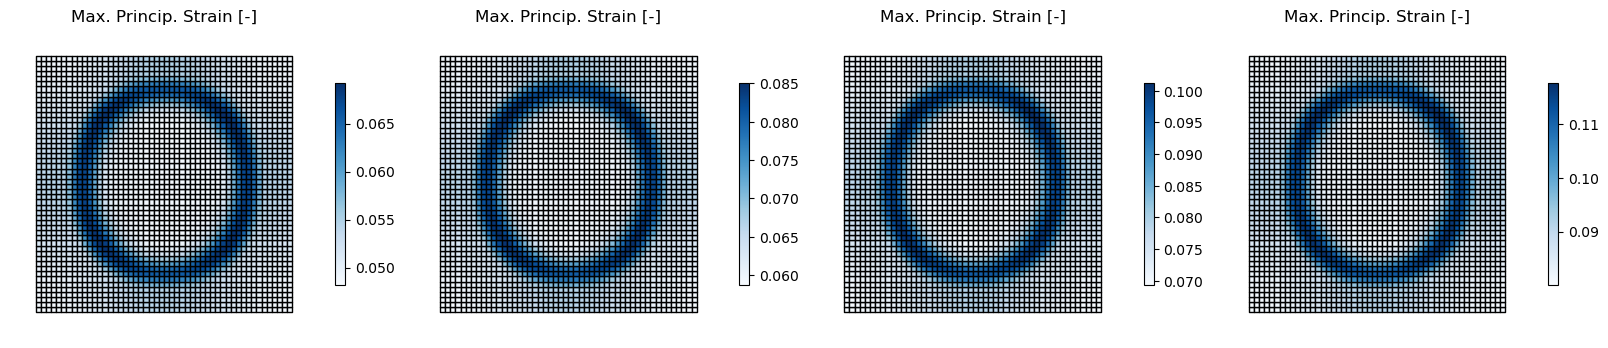

In [5]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, F, P, ax in zip(t_hist, F_hist_goh, P_hist_goh, axes):
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T

    mps = np.maximum(E_11, E_22)
    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 

    strains.append(np.array([t*np.ones(len(F)), F[:,0,0], F[:,0,1], F[:,1,0], F[:,1,1]]))
strains = np.hstack(strains)

### Coords_2_strain NN

In [6]:


n_ff = 20 # 10 cosines and 10 sines in the fourier features
n_inp = 2 # x, y

ff_params = random.normal(random.PRNGKey(0),shape=(n_inp,n_ff))*1
nn_layers = [2*n_ff+1,20,20,4]
nn_params = init_params_nn(nn_layers, key)
coord_2_strain_params =  nn_params

coords_2_strain_nn_ff = lambda x, params: coords_2_strain_nn(x, [ff_params, params])

# instead of using a 2D spline, use a NN to get the strain field for a given (x,y)
def loss_coords_2_strain(params, X, key):
    inp, out_gt = X[:,:3], X[:,3:] #inp: x,y,lmb and out_gt=eps_xx, eps_yy
    t = inp[:,2:3]
    out_pr = coords_2_strain_nn_ff(inp, params)
    out_gt = out_gt/(t+1) #dividing by t+1 just for some regularization
    out_pr = out_pr/(t+1) #dividing by t+1 just for some regularization
    return jnp.mean((out_pr-out_gt)**2)

opt_init, opt_update, get_params = optimizers.adam(5.e-4)
opt_state = opt_init(coord_2_strain_params)

X = np.vstack([elem_X, elem_X, elem_X, elem_X])
inp = np.hstack([X, strains.T])
coord_2_strain_params, train_loss, _ = train(loss_coords_2_strain, inp, get_params, opt_update, opt_state, key, nIter = 50000, print_freq=1000, batch_size=5000)

it 1000, train loss = 7.690419e-04
it 2000, train loss = 2.031625e-04
it 3000, train loss = 8.268540e-05
it 4000, train loss = 4.020017e-05
it 5000, train loss = 2.130763e-05
it 6000, train loss = 1.127543e-05
it 7000, train loss = 6.715444e-06
it 8000, train loss = 4.153582e-06
it 9000, train loss = 2.436933e-06
it 10000, train loss = 1.687468e-06
it 11000, train loss = 1.215055e-06
it 12000, train loss = 1.024030e-06
it 13000, train loss = 8.514851e-07
it 14000, train loss = 7.384678e-07
it 15000, train loss = 6.348711e-07
it 16000, train loss = 5.509824e-07
it 17000, train loss = 4.910851e-07
it 18000, train loss = 5.459910e-07
it 19000, train loss = 5.022684e-07
it 20000, train loss = 4.907138e-07
it 21000, train loss = 3.888435e-07
it 22000, train loss = 3.768239e-07
it 23000, train loss = 4.877097e-07
it 24000, train loss = 3.719625e-07
it 25000, train loss = 3.684838e-07
it 26000, train loss = 3.273671e-07
it 27000, train loss = 3.149371e-07
it 28000, train loss = 3.940827e-07
i

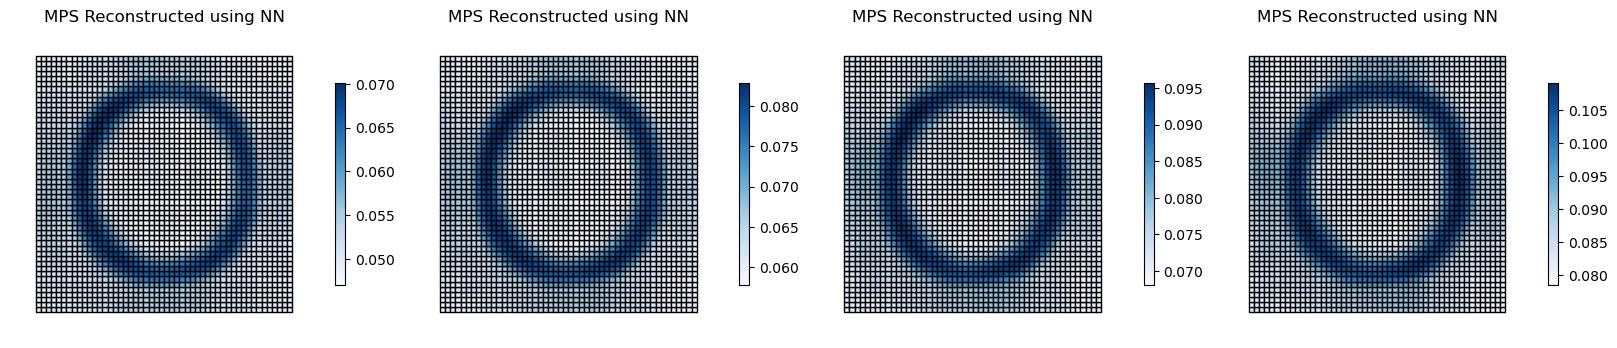

In [8]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
for t in t_hist[:4]:
    ax = axes[t]
    aux = np.hstack([elem_X, t*np.ones_like(elem_X[:,:1])])
    F_xx, F_xy, F_yx, F_yy = coords_2_strain_nn_ff(aux, coord_2_strain_params).T
    F = np.stack([F_xx, F_xy, F_yx, F_yy]).T.reshape([-1,2,2])
    
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T
    mps = np.maximum(E_11, E_22)

    plotmesh(mesh.cells, mesh.points, mps, title='MPS Reconstructed using NN', ax=ax); 

In [9]:
# identify the boundaries
rgt_bd_elems = []
top_bd_elems = []
lft_bd_elems = []
bot_bd_elems = []
for i, e in enumerate(mesh.cells):
    if any([mesh.points[e[i],0]>0.99 for i in range(4)]):
        rgt_bd_elems.append(i)
    if any([mesh.points[e[i],1]>0.99 for i in range(4)]):
        top_bd_elems.append(i)
    if any([mesh.points[e[i],0]<0.01 for i in range(4)]):
        lft_bd_elems.append(i)
    if any([mesh.points[e[i],1]<0.01 for i in range(4)]):
        bot_bd_elems.append(i)

# get the reaction forces by integrating the stresses of the boundary elements
rgt_bd_frc = np.sum(P_hist_goh[:,rgt_bd_elems,0,0], axis=1)
lft_bd_frc = np.sum(P_hist_goh[:,lft_bd_elems,0,0], axis=1)
top_bd_frc = np.sum(P_hist_goh[:,top_bd_elems,1,1], axis=1)
bot_bd_frc = np.sum(P_hist_goh[:,bot_bd_elems,1,1], axis=1)
Force_x = jnp.array(0.5*(rgt_bd_frc + lft_bd_frc))
Force_y = jnp.array(0.5*(top_bd_frc + bot_bd_frc))

# get the center points of the elements
rgt_bd_X = elem_X[rgt_bd_elems]
top_bd_X = elem_X[top_bd_elems]
lft_bd_X = elem_X[lft_bd_elems]
bot_bd_X = elem_X[bot_bd_elems]
bd_X = rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X

In [10]:
# Homogenize the strains
F_xx_mean = np.mean(F_hist_goh[:,:,0,0], axis=1)
F_xy_mean = np.mean(F_hist_goh[:,:,0,1], axis=1)
F_yx_mean = np.mean(F_hist_goh[:,:,1,0], axis=1)
F_yy_mean = np.mean(F_hist_goh[:,:,1,1], axis=1)

P_xx_mean = Force_x/len(rgt_bd_elems)
P_yy_mean = Force_y/len(top_bd_elems)
inputs = np.array([F_xx_mean, F_xy_mean, F_yx_mean, F_yy_mean, P_xx_mean, P_yy_mean]).T

n_neurons = 4
# Define the loss function for when training all params
@jit
def loss_stress(params, x, key):
    model = NODE_model_aniso(params)
    F_xx, F_xy, F_yx, F_yy, P_xx_gt, P_yy_gt = x.T
    P = eval_P_vmap(F_xx, F_xy, F_yx, F_yy, model)
    P_xx_pr, P_yy_pr = P[:,0,0], P[:,1,1]
    return np.mean((P_xx_pr-P_xx_gt)**2+(P_yy_pr-P_yy_gt)**2)

# Initialize NODEs and the optimizer
key = random.PRNGKey(0)
common_layers = [1, n_neurons, n_neurons]
sample_layers = [n_neurons,1]
node_params = init_params_aniso(common_layers, sample_layers, key)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(node_params)

# Train
node_params, train_loss, _ = train(loss_stress, inputs, get_params, opt_update, opt_state, key, nIter = 20000, print_freq=1000)

it 1000, train loss = 8.308635e-02
it 2000, train loss = 4.585339e-02
it 3000, train loss = 2.621229e-02
it 4000, train loss = 1.589915e-02
it 5000, train loss = 2.586835e-04
it 6000, train loss = 2.037871e-05
it 7000, train loss = 1.625466e-05
it 8000, train loss = 1.141357e-05
it 9000, train loss = 7.278257e-06
it 10000, train loss = 4.989074e-06
it 11000, train loss = 4.437009e-06
it 12000, train loss = 4.352539e-06
it 13000, train loss = 4.298688e-06
it 14000, train loss = 4.255701e-06
it 15000, train loss = 4.222512e-06
it 16000, train loss = 4.195361e-06
it 17000, train loss = 4.170046e-06
it 18000, train loss = 4.143815e-06
it 19000, train loss = 4.116074e-06
it 20000, train loss = 4.088086e-06


In [11]:
mymodel = NODE_model_aniso(node_params)
P = eval_P_vmap(F_xx_mean, F_xy_mean, F_yx_mean, F_yy_mean, mymodel)
P_xx_pr, P_yy_pr = P[:,0,0], P[:,1,1]
print('gt P_xx & P_yy: ', P_xx_mean, P_yy_mean)
print('pr P_xx & P_yy: ', P_xx_pr, P_yy_pr)

gt P_xx & P_yy:  [0.36047 0.42823 0.49318 0.55553 0.61546 0.67315 0.72876 0.78245 0.83436 0.88462 0.93335 0.98067 1.02668 1.07149 1.11519] [0.34807 0.41281 0.47461 0.53367 0.59018 0.6443  0.69621 0.74604 0.79394 0.84003 0.88443 0.92725 0.96859 1.00855 1.04722]
pr P_xx & P_yy:  [0.35719 0.42718 0.49376 0.55703 0.61723 0.67469 0.72973 0.78269 0.83387 0.88354 0.93195 0.97932 1.02585 1.07171 1.11705] [0.34488 0.41185 0.47526 0.53522 0.59197 0.64584 0.69715 0.74623 0.79337 0.83887 0.88295 0.92585 0.96775 1.00882 1.04922]


In [12]:
# Fit a function Λ that maps x,y ∈ [0,1] to the individual-specific parameters of this NODE with a maximum variance of, say, 1%
phi, unravel = ravel_pytree(node_params)
n_phi = len(phi)

# ff_params = coord_2_strain_params[0]
# ff_nn2 = lambda x, nn_params: ff_nn(x, [ff_params, nn_params])
def loss_Lambda(params, inp, key):
    out_pr = ff_nn_ff(inp, params)
    return jnp.mean((out_pr-phi)**2)

n_ff = 10
ff_params2 = random.normal(random.PRNGKey(1234), shape=(2, n_ff))
nn_layers = [2*n_ff,40,40,n_phi]
nn_params = init_params_nn(nn_layers, key)
Lambda_params =  nn_params

ff_nn_ff = lambda x, params: ff_nn(x, [ff_params2,params])


opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(Lambda_params)

inp = np.array(np.meshgrid(np.linspace(0,1,20), np.linspace(0,1,20))).reshape([2,-1]).T
Lambda_params, train_loss, _ = train(loss_Lambda, inp, get_params, opt_update, opt_state, key, nIter = 5000, print_freq=1000)

it 1000, train loss = 4.464547e-04
it 2000, train loss = 1.370790e-04
it 3000, train loss = 5.893749e-05
it 4000, train loss = 2.902632e-05
it 5000, train loss = 1.541928e-05


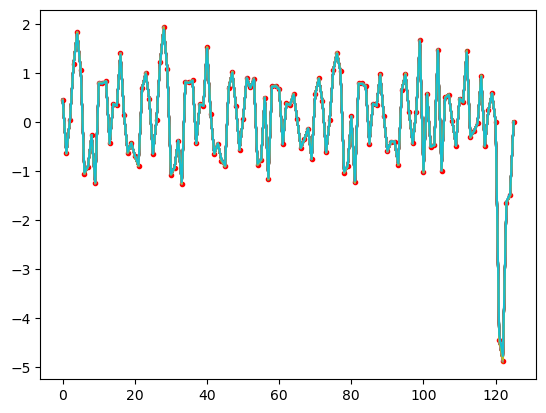

In [13]:
fig, ax = plt.subplots()
ax.plot(phi, 'r.-')
for y in np.linspace(0,1,4):
    for x in np.linspace(0,1,10):
        params = ff_nn_ff(np.array([x,y]).reshape([1,-1]), Lambda_params)
        ax.plot(params[0])

In [14]:
with open('params/O_pre.npy', 'wb') as f:
    pickle.dump([coord_2_strain_params, node_params, Lambda_params, mesh, elem_X, Force_x, Force_y, strains,
                 bd_X, lmb_hist, P_hist_goh, F_hist_goh, t_hist], f)

## 2. Retrain

In [33]:
with open('params/O_pre.npy', 'rb') as f:
    coord_2_strain_params, node_params, Lambda_params, mesh, elem_X, Force_x, Force_y, strains, \
                 bd_X, lmb_hist, P_hist_goh, F_hist_goh, t_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

In [34]:
def get_P(X, Y, t, Lambda_params, coord_2_strain_params, model):
    F_xx, F_xy, F_yx, F_yy = coords_2_strain_nn_ff(jnp.array([X,Y,t])[None,:], coord_2_strain_params).flatten()
    # get NODE individual-specific params, phi, from the Lambda NN
    Lambda_inp = jnp.array([X,Y]).reshape([-1,2])
    phi = ff_nn_ff(Lambda_inp, Lambda_params).flatten()
    # Make predictions with this NODE
    ugrad = jnp.array([[F_xx-1.0, F_xy],[F_yx, F_yy-1.0]])
    P = ThreeDElasticity(model).ugrad_2_P(ugrad, phi, 2)
    return P[0,0], P[1,0], P[0,1], P[1,1]
get_P_vmap = vmap(get_P, in_axes=(0,0,0,None,None,None), out_axes=(0,0,0,0))

get_Pxx = lambda X, Y, t, a, b, c: get_P(X, Y, t, a, b, c)[0]
get_Pyx = lambda X, Y, t, a, b, c: get_P(X, Y, t, a, b, c)[1]
get_Pxy = lambda X, Y, t, a, b, c: get_P(X, Y, t, a, b, c)[2]
get_Pyy = lambda X, Y, t, a, b, c: get_P(X, Y, t, a, b, c)[3]

Grad_Pxx_X = vmap(grad(get_Pxx, argnums=0), in_axes=(0,0,0,None,None,None), out_axes=0) # should return dsgm_xx/dx
Grad_Pyx_X = vmap(grad(get_Pyx, argnums=0), in_axes=(0,0,0,None,None,None), out_axes=0)
Grad_Pxy_Y = vmap(grad(get_Pyx, argnums=1), in_axes=(0,0,0,None,None,None), out_axes=0)
Grad_Pyy_Y = vmap(grad(get_Pyy, argnums=1), in_axes=(0,0,0,None,None,None), out_axes=0)

@partial(jit, static_argnums=(4,))
def bd_forces(Lambda_params, t, bd_X, c2s_params, model):
    rgt_bd_X, top_bd_X, lft_bd_X, bot_bd_X = bd_X
    rgt_bd_P = get_P_vmap(rgt_bd_X[:,0], rgt_bd_X[:,1], t*jnp.ones_like(rgt_bd_X[:,0]), Lambda_params, c2s_params, model)
    top_bd_P = get_P_vmap(top_bd_X[:,0], top_bd_X[:,1], t*jnp.ones_like(top_bd_X[:,0]), Lambda_params, c2s_params, model)
    lft_bd_P = get_P_vmap(lft_bd_X[:,0], lft_bd_X[:,1], t*jnp.ones_like(lft_bd_X[:,0]), Lambda_params, c2s_params, model)
    bot_bd_P = get_P_vmap(bot_bd_X[:,0], bot_bd_X[:,1], t*jnp.ones_like(bot_bd_X[:,0]), Lambda_params, c2s_params, model)

    rgt_bd_frc = jnp.sum(rgt_bd_P[0]*1.0) # Assume area of edge = 1.0
    top_bd_frc = jnp.sum(top_bd_P[3]*1.0)
    lft_bd_frc = jnp.sum(lft_bd_P[0]*1.0)
    bot_bd_frc = jnp.sum(bot_bd_P[3]*1.0)
    return rgt_bd_frc, top_bd_frc, lft_bd_frc, bot_bd_frc

@partial(jit, static_argnums=(3,))
def divergence(Lambda_params, XYt, c2s_params, model):
    dPxx_dX = Grad_Pxx_X(XYt[:,0], XYt[:,1], XYt[:,2], Lambda_params, c2s_params, model)
    dPxy_dY = Grad_Pxy_Y(XYt[:,0], XYt[:,1], XYt[:,2], Lambda_params, c2s_params, model)
    dPyx_dX = Grad_Pyx_X(XYt[:,0], XYt[:,1], XYt[:,2], Lambda_params, c2s_params, model)
    dPyy_dY = Grad_Pyy_Y(XYt[:,0], XYt[:,1], XYt[:,2], Lambda_params, c2s_params, model)
    
    Div_X = jnp.mean(dPxx_dX + dPxy_dY)
    Div_Y = jnp.mean(dPyx_dX + dPyy_dY)
    return Div_X, Div_Y

In [35]:
P_xx_mean

Array([0.36047, 0.42823, 0.49318, 0.55553, 0.61546, 0.67315, 0.72876, 0.78245, 0.83436, 0.88462, 0.93335, 0.98067, 1.02668, 1.07149, 1.11519], dtype=float64)

In [39]:
# Train
a1 = 10000
@jit
def loss(Lambda_params, XYt_colloc):

    P_pred = get_P_vmap(XYt_colloc[:,0],XYt_colloc[:,1], XYt_colloc[:,2], Lambda_params, coord_2_strain_params, NODE_w_unravel)
    P_xx = P_xx_mean[jnp.array(t, int)]
    P_yy = P_yy_mean[jnp.array(t, int)]

    loss_P = jnp.mean((P_pred[0] - P_xx)**2 + (P_pred[3] - P_yy)**2)
    # loss_F = 0.0
    
    return loss_P

lr = optimizers.exponential_decay(1e-6, 10000, 0.9)
sharding = PositionalSharding(jax.devices()).reshape(n_cores, 1)
opt_init, opt_update, get_params = optimizers.adam(lr) 
opt_state = opt_init(Lambda_params)

node_X_ext = jnp.hstack([mesh.points, t_hist[-1]*np.ones_like(mesh.points[:,:1])])
metric1 = lambda params, X:  bd_forces(params, t_hist[-1], bd_X, coord_2_strain_params, NODE_w_unravel)
metric2 = lambda params, X: divergence(params, node_X_ext, coord_2_strain_params, NODE_w_unravel)

Lambda_params, val_loss, metrics = train_colloc(loss, [mesh.points, t_hist], get_params, opt_update, opt_state, 
                                            key, sharding, 'cross', nIter = 1000, print_freq=100, batch_size=1000)

# with open('params/O_post.npy', 'wb') as f:
#     pickle.dump([mesh, elem_X, strains, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics, t_hist, lmb_hist], f)

it 100, val loss = 3.409711e-03
it 200, val loss = 3.456857e-03
it 300, val loss = 3.459535e-03
it 400, val loss = 3.465811e-03
it 500, val loss = 3.423095e-03
it 600, val loss = 3.418862e-03
it 700, val loss = 3.358679e-03
it 800, val loss = 3.486320e-03
it 900, val loss = 3.443859e-03
it 1000, val loss = 3.394503e-03


In [41]:
# Train
a1 = 10000
@jit
def loss(Lambda_params, XYt_colloc):
    Div_x, Div_y = divergence(Lambda_params, XYt_colloc, coord_2_strain_params, NODE_w_unravel)
    loss_Div = a1*(Div_x**2 + Div_y**2)

    def bd_forces_loss(_, t):
        F_rgt, F_top, F_lft, F_bot = bd_forces(Lambda_params, t, bd_X, coord_2_strain_params, NODE_w_unravel)
        Fx = Force_x[jnp.array(t, int)]
        Fy = Force_y[jnp.array(t, int)]
        return None, a2*((F_rgt-Fx)**2 + (F_top-Fy)**2 + (F_lft-Fx)**2 + (F_bot-Fy)**2)
    loss_F = jnp.mean(scan(bd_forces_loss, init=None, xs=t_hist)[1])
    # loss_F = 0.0
    
    return loss_Div + loss_F

lr = optimizers.exponential_decay(1e-4, 1000, 0.9)
sharding = PositionalSharding(jax.devices()).reshape(n_cores, 1)
opt_init, opt_update, get_params = optimizers.adam(lr) 
opt_state = opt_init(Lambda_params)

node_X_ext = jnp.hstack([mesh.points, t_hist[-1]*np.ones_like(mesh.points[:,:1])])
metric1 = lambda params, X:  bd_forces(params, t_hist[-1], bd_X, coord_2_strain_params, NODE_w_unravel)
metric2 = lambda params, X: divergence(params, node_X_ext, coord_2_strain_params, NODE_w_unravel)

Lambda_params, val_loss, metrics = train_colloc(loss, [mesh.points, t_hist], get_params, opt_update, opt_state, 
                                            key, sharding, 'cross', nIter = 5000, print_freq=100, batch_size=1000)

with open('params/O_post.npy', 'wb') as f:
    pickle.dump([mesh, elem_X, strains, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics, t_hist, lmb_hist], f)

it 100, val loss = 1.451328e+02
it 200, val loss = 7.000675e+01
it 300, val loss = 5.255558e+01
it 400, val loss = 2.397172e+01
it 500, val loss = 5.442552e+00
it 600, val loss = 5.315294e+00
it 700, val loss = 3.597529e+00
it 800, val loss = 3.911182e+00
it 900, val loss = 2.810330e+00
it 1000, val loss = 3.206291e+00
it 1100, val loss = 3.515596e+00
it 1200, val loss = 3.336854e+00
it 1300, val loss = 3.892682e+00
it 1400, val loss = 3.653135e+00
it 1500, val loss = 3.335043e+00
it 1600, val loss = 1.452298e+00
it 1700, val loss = 9.820834e-01
it 1800, val loss = 2.789935e+00
it 1900, val loss = 1.471846e+00
it 2000, val loss = 1.654150e+00
it 2100, val loss = 1.108395e+00
it 2200, val loss = 2.789326e+00
it 2300, val loss = 2.232200e+00
it 2400, val loss = 2.904286e+00
it 2500, val loss = 1.334182e+00
it 2600, val loss = 9.317018e-01
it 2700, val loss = 5.253873e-01
it 2800, val loss = 8.372148e-01
it 2900, val loss = 2.387351e+00
it 3000, val loss = 8.949150e-01
it 3100, val loss =

KeyboardInterrupt: 

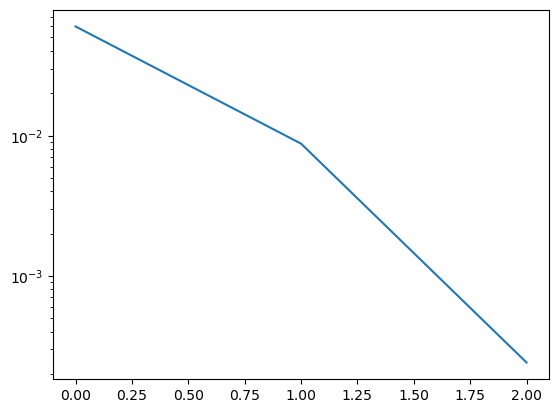

In [30]:
plt.plot(val_loss)
plt.yscale('log')

## 3. Test

In [25]:
with open('params/O_post.npy', 'rb') as f:
    mesh, elem_X, strains, Force_x, Force_y, node_params, Lambda_params, val_loss, metrics, t_hist, lmb_hist = pickle.load(f)
_, unravel = ravel_pytree(node_params)
NODE_w_unravel = lambda params: NODE_model_aniso(unravel(params))

In [26]:
lmb_hist

array([1.05   , 1.06071, 1.07143, 1.08214, 1.09286, 1.10357, 1.11429, 1.125  , 1.13571, 1.14643, 1.15714, 1.16786, 1.17857, 1.18929, 1.2    ])

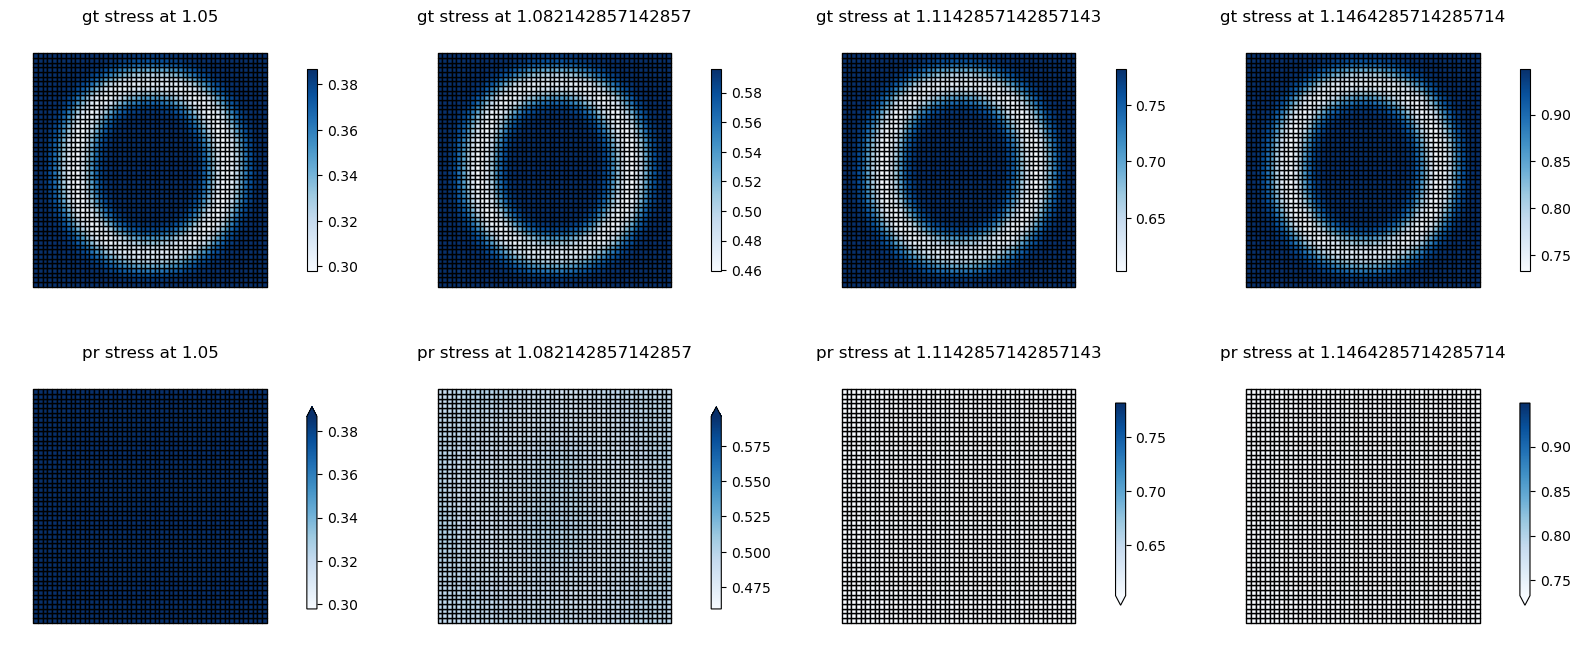

In [31]:
# Stiffness across the domain
fig, axes = plt.subplots(2,4,figsize=(20,8))
for lmb, ax in zip(lmb_hist[::3], axes.T):
    ugrad = jnp.array([[lmb-1.0, 0.0], [0.0, lmb-1.0]])

    params_gt = []
    for xy in elem_X:
        params_gt.append(coords_2_params_gt(xy))
    params_gt = np.array(params_gt)
    params_pr = ff_nn_ff(elem_X, Lambda_params)

    c_elem_gt = []
    c_elem_pr = []
    for params_gt_i, params_pr_i in zip(params_gt, params_pr):
        c_elem_gt.append(ThreeDElasticity(GOH_model).ugrad_2_P(ugrad, params_gt_i, 2)[0,0])
        c_elem_pr.append(ThreeDElasticity(NODE_w_unravel).ugrad_2_P(ugrad, params_pr_i, 2)[0,0])
    
    plotmesh(mesh.cells, mesh.points, c_elem_gt, title='gt stress at {}'.format(str(lmb)), ax=ax[0]); 
    extent = [np.min(c_elem_gt), np.max(c_elem_gt)]
    if extent[0] > np.min(c_elem_pr) and extent[1] < np.max(c_elem_pr):
        extend='both'
    elif extent[0] > np.min(c_elem_pr):
        extend='min'
    elif extent[1] < np.max(c_elem_pr):
        extend='max'
    plotmesh(mesh.cells, mesh.points, c_elem_pr, title='pr stress at {}'.format(str(lmb)), ax=ax[1], extent=extent, extend=extend); 

In [57]:
P_vmap = vmap(ThreeDElasticity(NODE_w_unravel).ugrad_2_P, in_axes=(0, 0, None))
class HyperElasticity(FEM):
    def get_tensor_map(self):
        return lambda u_grad, params: ThreeDElasticity(NODE_w_unravel).ugrad_2_P(u_grad, params, self.dim)
    
    def set_params(self, params_vec):
        self.internal_vars['laplace'] = [params_vec]

In [60]:
params_vec = []
for x, y in elem_X:
    Lambda_inp = np.array([x,y]).reshape([-1,2])
    phi = ff_nn_ff(Lambda_inp, Lambda_params).flatten()
    params_vec.append(phi)
params_vec = jnp.array(params_vec).reshape([len(params_vec),1,-1])
params_vec = jnp.repeat(params_vec, axis=1, repeats=4)

In [63]:
ele_type = 'QUAD4'
cell_type = get_meshio_cell_type(ele_type)

Nx, Ny = 19, 19
Lx, Ly = 1.0, 1.0
meshio_mesh = rectangle_mesh(Nx=Nx, Ny=Ny, domain_x=Lx, domain_y=Ly)
mesh = Mesh(meshio_mesh.points, meshio_mesh.cells_dict[cell_type])


# Functions to identify the boundary nodes
def bottom(point):
    return jnp.isclose(point[1], 0., atol=1e-5)
def left(point):
    return jnp.isclose(point[0], 0., atol=1e-5)
def top(point):
    return jnp.isclose(point[1], Ly, atol=1e-5)
def right(point):
    return jnp.isclose(point[0], Lx, atol=1e-5)
def bottom_left(point):
    return jnp.logical_and(jnp.logical_and(bottom(point), left(point)), jnp.isclose(point[2], 0., atol=1e-5))


# Functions to assign dirichlet BCs
def zero_dirichlet(point):
    return 0.
def lmbx_max_dirichlet(point, lmbx_max):
    return Lx*lmbx_max - 1.0
def lmby_max_dirichlet(point, lmby_max):
    return Ly*lmby_max - 1.0


lmb_hist = [1.05, 1.10, 1.15, 1.20]
n_elem = Nx*Ny
C10 = jnp.zeros(n_elem)
k1  = jnp.zeros(n_elem)
k2  = jnp.zeros(n_elem)
F_hist = []
node_x_hist = []
P_hist = []
for lmb_max in lmb_hist:
    dirichlet_bc_info = [
        [bottom,            left,           top,                                        right,                                  ],
        [1,                 0,              1,                                          0,                                      ],
        [zero_dirichlet,    zero_dirichlet, lambda p: lmby_max_dirichlet(p, lmb_max),   lambda p: lmbx_max_dirichlet(p, lmb_max)]
    ]
    problem = HyperElasticity(mesh,
                            vec=2,
                            dim=2,
                            ele_type=ele_type,
                            dirichlet_bc_info=dirichlet_bc_info)
    elem_X = problem.get_physical_quad_points().mean(1)

    problem.set_params(params_vec)


    node_x = solver(problem, use_petsc=True)
    u_grad = np.mean(problem.sol_to_grad(node_x), axis=1)
    F = u_grad + np.eye(2)
    P = P_vmap(u_grad, params_vec[:,0,:], 2)
    
    F_hist.append(F)
    node_x_hist.append(node_x)
    P_hist.append(P)
node_x_hist = np.array(node_x_hist)
F_hist = np.array(F_hist)
P_hist = np.array(P_hist)

[04-26 10:25:16][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[04-26 10:25:16][DEBUG] jax_fem: ele_type = QUAD4, quad_points.shape = (num_quads, dim) = (4, 2)
[04-26 10:25:16][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (4, 2, 2)


[04-26 10:25:17][DEBUG] jax_fem: Done pre-computations, took 0.2795231342315674 [s]
[04-26 10:25:17][INFO] jax_fem: Solving a problem with 2500 cells, 2601x2 = 5202 dofs.
[04-26 10:25:17][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[04-26 10:25:17][DEBUG] jax_fem: Start timing
[04-26 10:25:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (4 of them) had size 125, e.g. axis 0 of argument cell_sol of type float64[125,4,2];
  * one axis had size 111: axis 0 of argument args[4][0] of type float64[111,4,126]

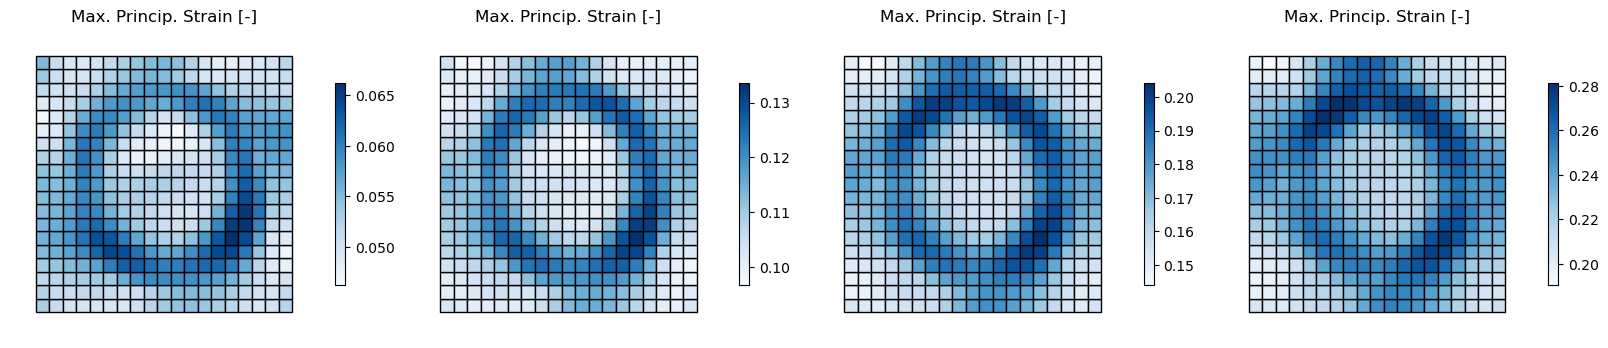

In [62]:
fig, axes = plt.subplots(1,4,figsize=(20,4))
strains = []
t_hist = np.arange(len(lmb_hist))
for t, node_x, F, ax in zip(t_hist, node_x_hist, F_hist, axes):
    E = E_fun(F)
    evals, efuns = jnp.linalg.eigh(E)
    E_11, E_22 = evals.T

    mps = np.maximum(E_11, E_22)
    plotmesh(mesh.cells, mesh.points, mps, title='Max. Princip. Strain [-]', ax=ax); 